In [1]:
import hopsworks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import numpy as np
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/191638
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
weather_fg = fs.get_feature_group(name="weather", version=1)
#query = weather_fg.select_all()
"""
feature_view = fs.get_or_create_feature_view(name="weather",
                                  version=1,
                                  description="",
                                  labels=['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'day_cos', 'day_sin', 'hour_cos', 'hour_sin'],
                                  query=query)
# You can read training data, randomly split into train/test sets of features (X) and labels (y)

X_train, X_test, y_train, y_test = feature_view.train_test_split(
    train_start="2023-01-01",
    train_end="2023-09-13",    
    test_start="2023-09-14", 
    test_end="2023-12-31", 
    description='Weather dataset for 2023'
)
"""

'\nfeature_view = fs.get_or_create_feature_view(name="weather",\n                                  version=1,\n                                  description="",\n                                  labels=[\'temperature_2m\', \'apparent_temperature\', \'rain\', \'snowfall\', \'surface_pressure\', \'cloud_cover\', \'wind_speed_10m\', \'wind_direction_10m\', \'day_cos\', \'day_sin\', \'hour_cos\', \'hour_sin\'],\n                                  query=query)\n# You can read training data, randomly split into train/test sets of features (X) and labels (y)\n\nX_train, X_test, y_train, y_test = feature_view.train_test_split(\n    train_start="2023-01-01",\n    train_end="2023-09-13",    \n    test_start="2023-09-14", \n    test_end="2023-12-31", \n    description=\'Weather dataset for 2023\'\n)\n'

In [4]:
X_data = weather_fg.read()
print(X_data)
# Use less data for testing
raw_X_data = X_data.sort_values(by='date').drop(columns=['date'])
raw_X_data = raw_X_data.to_numpy()
# Scale the input data!

scaler = StandardScaler()
scaler.fit(raw_X_data[:, :8])
raw_X_data[:, :8] = scaler.transform(raw_X_data[:, :8])


Finished: Reading data from Hopsworks, using ArrowFlight (2.11s) from Hopsworks, using ArrowFlight.   
                           date  temperature_2m  apparent_temperature  rain  \
0     2021-09-02 05:00:00+00:00        8.014999              4.672139   0.0   
1     2019-10-05 11:00:00+00:00        6.965000              2.668015   0.0   
2     2021-03-04 08:00:00+00:00       -0.585000             -5.597241   0.0   
3     2023-10-05 23:00:00+00:00        6.265000              3.872746   0.0   
4     2018-04-13 04:00:00+00:00        0.165000             -4.198921   0.0   
...                         ...             ...                   ...   ...   
52435 2020-07-11 08:00:00+00:00       13.514999             11.995792   0.0   
52436 2020-02-28 00:00:00+00:00       -2.735000             -6.774117   0.0   
52437 2022-03-18 23:00:00+00:00        0.015000             -4.083844   0.0   
52438 2022-07-26 05:00:00+00:00       17.565001             18.175024   0.8   
52439 2023-11-25 10:00:00+00

In [5]:
# For LSTM model only
def create_windows(data, window_size, step=1):
    X, y = [], []
    for i in range(0, len(data) - window_size, step):
        # Create sequences (windows) of data
        X.append(data[i:(i + window_size)])
        # Append the target variable, the next value after the window
        y.append(data[i + window_size, :8])
    return np.array(X), np.array(y)

X_data, Y_data = create_windows(raw_X_data, 24)

X_train, X_test, Y_train, Y_test = train_test_split(X_data.copy(), Y_data.copy(), test_size=0.2, random_state=42, shuffle=True)

In [6]:
class LSTMWeatherModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_out, num_layers):
        super(LSTMWeatherModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_layer_size = n_hidden

        # Stacked LSTM layer
        self.lstm = nn.LSTM(n_input, n_hidden, num_layers, batch_first=True)

        self.linear1 = nn.Linear(n_hidden, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, n_out)


    def forward(self, x):
        # Stacked LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]

        # Regular feed forward network
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x

n_input = 12 # Number of features
n_hidden = 128  # Number of hidden nodes
n_out = 8 # Number of classes
num_layers = 2


model = LSTMWeatherModel(n_input, n_hidden, n_out, num_layers)

In [7]:
# Hyper-parameters
epochs = 50
batch_size = 512
learning_rate = 0.0005
w_decay = 0.0005

# Define loss function, optimizer, and convert data to tensors
loss_fun = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=w_decay)
x_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(Y_train, dtype=torch.float32)
x_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(Y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# Define dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_loss_array = []
val_loss_array = []

# Training loop
epoch_loop = tqdm(range(epochs), desc=f"Epoch {1}/{epochs}")
for epoch in epoch_loop:
    train_loss = 0
    val_loss = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fun(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation loop with tqdm
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            val_loss += loss_fun(outputs, batch_y).item()
        val_loss /= len(test_loader)
        epoch_loop.set_description(f"Epoch {epoch + 1}/{epochs} [Train Loss: {train_loss:.4f}] [Validation Loss: {val_loss:.4f}]")

        train_loss_array.append(train_loss)
        val_loss_array.append(val_loss)


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

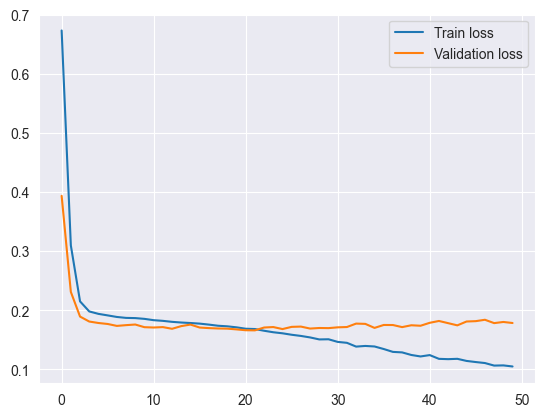

In [8]:
plt.plot(range(len(train_loss_array)), train_loss_array, label='Train loss')
plt.plot(range(len(val_loss_array)), val_loss_array, label='Validation loss')
plt.legend()
plt.show()

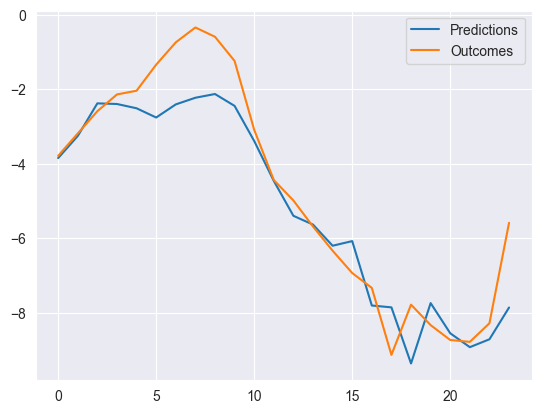

[[[-8.01618234e-01 -8.19173893e-01  1.13806657e+00 ...  6.43249060e-16
    9.65925826e-01 -2.58819045e-01]
  [-7.89371322e-01 -7.41146611e-01  1.13806677e+00 ...  1.72133562e-02
    1.00000000e+00  0.00000000e+00]
  [-7.09766307e-01 -6.91681007e-01  4.63561517e-01 ...  1.72133562e-02
    9.65925826e-01  2.58819045e-01]
  ...
  [-5.87297071e-01 -5.41219031e-01  4.63561517e-01 ...  1.72133562e-02
    5.00000000e-01 -8.66025404e-01]
  [-7.22013248e-01 -7.50046260e-01  8.00814120e-01 ...  1.72133562e-02
    7.07106781e-01 -7.07106781e-01]
  [-8.07741719e-01 -8.69213926e-01  1.26308938e-01 ...  1.72133562e-02
    8.66025404e-01 -5.00000000e-01]]

 [[-7.89371322e-01 -7.41146611e-01  1.13806677e+00 ...  1.72133562e-02
    1.00000000e+00  0.00000000e+00]
  [-7.09766307e-01 -6.91681007e-01  4.63561517e-01 ...  1.72133562e-02
    9.65925826e-01  2.58819045e-01]
  [-6.54655145e-01 -6.27938363e-01 -2.10943640e-01 ...  1.72133562e-02
    8.66025404e-01  5.00000000e-01]
  ...
  [-7.22013248e-01 -7.5

In [11]:
# Try to plot features over 2 days amd compare to true values
test_data = raw_X_data.copy()[2000:2048]

test_x_data, test_y_data = create_windows(test_data, 24)

predictions = model(torch.tensor(test_x_data, dtype=torch.float32))

predictions = scaler.inverse_transform(predictions.detach().numpy())
outcomes = scaler.inverse_transform(test_y_data)
plt.plot(range(24), predictions[:, 0], label='Predictions')
plt.plot(range(24), outcomes[:, 0], label='Outcomes')
plt.legend()
plt.show()

print(X_data)

In [12]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="trained_models"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
model_scripted = torch.jit.script(model)
model_scripted.save(model_dir + '/weather_model.pth')

# Save the standardizer since it is needed for inference!
joblib.dump(scaler, model_dir + '/scaler.save')

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(Y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
weather_model = mr.python.create_model(
    name="weather_model",
    metrics={"Validation MSE" : val_loss_array[-1]},
    model_schema=model_schema,
    description="Weather predictor for Stockholm"
)

# Upload the model to the model registry, including all files in 'model_dir'
weather_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/807 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/972393 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/235 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/191638/models/weather_model/1


Model(name: 'weather_model', version: 1)